In [7]:
import numpy as np
import jax.numpy as jnp
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from pylab import figure, cm
from jax import grad, hessian, jit, vmap
from jax.nn import celu
import time
from functools import partial
from IPython.display import clear_output

N = 2
# true_E = N*omega/2 -  g**2/24 * N * (N**2 - 1)
omega = 10
g = 1
hbar = 1
m = 1
true = (N * hbar * omega)/2


In [8]:
class Network:
    def __init__(self, node_counts=[N, 5, 10, 10, 10, 10, 5, 1]):
        # defining the structure of the neural network
        self.num_layers = len(node_counts)
        # the number of nodes for each layer
        self.node_counts = node_counts
        # the total number of weights
        self.params_length = 0
        for i in range(self.num_layers - 1):
            self.params_length += node_counts[i] * node_counts[i + 1]
            i+=1
        # the list that stores the weight matrices (index 0 is the connections from the input to the first hidden layer)
        self.weights = []
        # generate weight matrices with the correct sizes, and random elements
        for i in range(self.num_layers - 1):
            self.weights.append(np.random.randn(node_counts[i + 1], node_counts[i]) * np.sqrt(1. / node_counts[i + 1]))
        self.weights = np.array(self.weights, dtype=object)
        
        # get the shape for reshaping a 1d array to this later
        self.dimensions = []
        for m in self.weights:
            self.dimensions.append(m.shape)

    # define the activation function that we use for the layers
    @partial(jit, static_argnums=[0])
    def l_act(self, x):
        return celu(x)
        #return 1.0 / (1.0 + jnp.exp(-x))    
    # define the activation function for the output
    @partial(jit, static_argnums=[0])
    def o_act(self, x):
        return celu(x)
        #return 1.0 / (1.0 + jnp.exp(-x))
    
    @partial(jit, static_argnums=(0,))
    def conv1d(self):
        #start = time.time()
        flattened = []
        # loop through each matrix
        for m in range(self.num_layers - 1):
            mat = self.weights[m]
            for i in range(mat.shape[0]):
                for j in range(mat.shape[1]):
                    flattened.append(mat[i][j])
        #end = time.time()
        #print("conv1d: " + str(end - start))
        return jnp.array(flattened)
        
    @partial(jit, static_argnums=(0,))
    def convnd(self, params):
        #start = time.time()
        ret = []
        # the last index of the matrix
        max_ind = 0
        prev_ind = 0
        for dim in self.dimensions:
            max_ind += dim[0]*dim[1]
            temp = params[prev_ind : max_ind]
            prev_ind = max_ind
            ret.append(jnp.array(temp).reshape(dim))
        #end = time.time()
        #print("convnd: " + str(end - start))
        return ret


    # passing inputs into the neural network and getting an output
    @partial(jit, static_argnums=[0])
    def output(self, coords, params):
        # start = time.time()
        # sort the input coordinates in order to enforce particle swap invariance
        jnp.sort(coords)
        # format the parameters as weights
        self.weights = self.convnd(params)
        # compute the output of the neural network
        for i in range(self.num_layers - 1):
            w = jnp.array(self.weights[i])
            # if its the first layer, dot it against the input and use the activation function
            if i == 0:
                temp = self.l_act(jnp.dot(w, coords))
            elif (i < self.num_layers):
                temp = self.l_act(jnp.dot(w, temp))
            else:
                # on the output layer we se the output activation function
                temp = self.o_act(jnp.dot(w, temp))
        # print("output:" + str(time.time() -  start))
        return temp[0]

# create the network object
nn = Network()

# defines the wavefunction based on calls to the neural network
@jit
def psi(coords, params):
    coords = jnp.array(coords)
    return jnp.exp(-nn.output(coords, params)) * jnp.exp(-jnp.dot(coords,coords))

def sample(params, num_particles, num_samples):
    # random.seed(seed)
    outputs = []
    coords_t = np.zeros(num_particles)
    for _ in range(num_samples):
        coords_prime = coords_t + np.random.uniform(-1,1,num_particles)
        if (np.random.uniform(0,1) < psi(coords_prime, params)**2/psi(coords_t, params)**2):
            coords_t = coords_prime
        outputs.append(coords_t)
    return jnp.array(outputs)

# computes the hessian matrix, has all the second order partials
h = jit(hessian(psi))
# return the second derivative of the wavefunction with respect to every parameter
@jit
def ddpsi(coords, params):
    return jnp.diagonal(h(coords, params))

# now we define the Hamiltonian
# In this case, we have the kinetic term and the harmonic oscillator term

@jit
def Hpsi(coords, params, omega, num_particles):
    temp = psi(coords, params) * (m*.5*omega**2*jnp.dot(coords, coords)) - hbar**2 / (2*m) * jnp.sum(ddpsi(coords, params))
    return temp/psi(coords, params)

venergy = vmap(Hpsi, in_axes=(0, None, None, None), out_axes=0)

@jit
def logpsi(coords, params):
    return jnp.log(psi(coords, params))

# define the derivative with respect to every parameter of the log of psi:
dlogpsi_dtheta_stored = jit(grad(logpsi, 1))

vlog_term = jit(vmap(dlogpsi_dtheta_stored, in_axes=(0, None), out_axes=0))

vboth = vmap(jnp.multiply, in_axes=(0, 0), out_axes=0)

def gradient(params, omega, num_particles, num_samples=10**3):
    # get the samples
    samples = sample(params, num_particles, num_samples)
    psiHpsi = venergy(samples, params, omega, num_particles)
    logs = vlog_term(samples, params)
    
    energy = 1/num_samples * jnp.sum(psiHpsi)
    print(energy)
    log_term = 1/num_samples * jnp.sum(logs,0)

    both = 1/num_samples * jnp.sum(vboth(psiHpsi, logs),0)

    gradient_calc = (2 * both - 2*energy * log_term)
    return gradient_calc


def avg_energy(params, omega, num_particles, num_samples = 10**3):
    samples = sample(params, num_particles, num_samples)
    psiHpsi = venergy(samples, params, omega, num_particles)
    return 1/num_samples * jnp.sum(psiHpsi)
    
def vgrad_opt(start_params, omega, num_particles, num_samples=10**3, learning_rate=.01, max_iterations=100, tolerance=.001):
    params = start_params
    hist = [start_params]

    for it in range(max_iterations):
        clear_output(wait=True)
        diff = jnp.asarray((learning_rate * gradient(params, omega, num_particles, num_samples)))
        #print(diff)
        if all((abs(val) < tolerance) for val in diff):
            print("All under tolerance")
            return hist
        # make a step in the direction opposite the gradient
        params = params - diff
        # print(params)
        hist.append(params)
    return hist

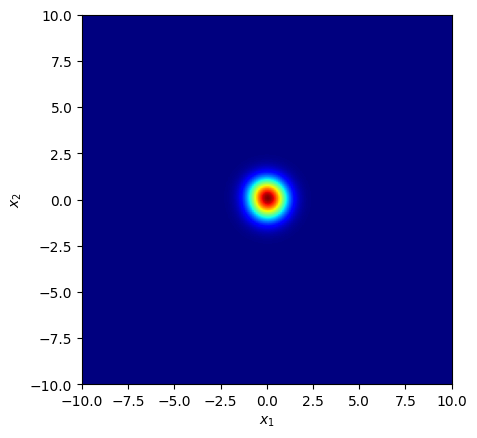

In [9]:
# plotting the wavefunction
size = 200
xmin = -10
xmax = 10
ymin = -10
ymax = 10
X = np.linspace(xmin, xmax, size)
Y = np.linspace(ymin, ymax, size)
mesh = [[psi([i, j], nn.conv1d()) for i in X] for j in Y]
fig = plt.figure()
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
im = plt.imshow(mesh, cmap=plt.get_cmap('jet'), extent=[xmin, xmax, ymin, ymax], origin='lower')
plt.show()


In [10]:
optd = vgrad_opt(nn.conv1d(), omega,N)
#print(optd[-1])

13.077841


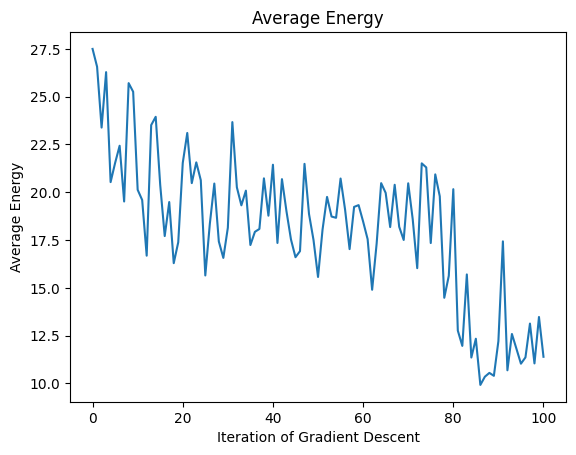

In [11]:
# plot the energy over the course of the optimization
ys = []
for param in optd:
    ys.append(avg_energy(param, omega, N))

plt.title("Average Energy")
plt.xlabel("Iteration of Gradient Descent")
plt.ylabel("Average Energy")
plt.plot(np.arange(0,len(optd)),ys)
plt.show()

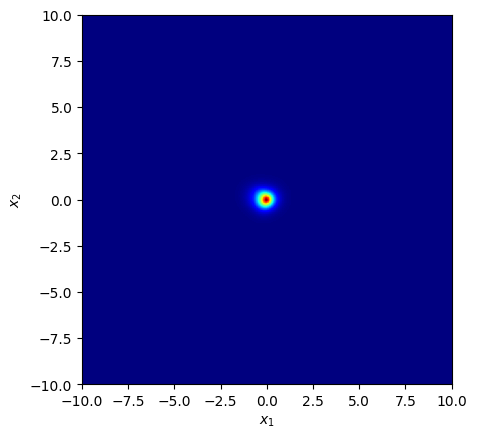

In [12]:
# plotting the wavefunction
size = 200
xmin = -10
xmax = 10
ymin = -10
ymax = 10
X = np.linspace(xmin, xmax, size)
Y = np.linspace(ymin, ymax, size)
mesh = [[psi([i, j], optd[-1]) for i in X] for j in Y]
fig = plt.figure()
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
im = plt.imshow(mesh, cmap=plt.get_cmap('jet'), extent=[xmin, xmax, ymin, ymax], origin='lower')
plt.show()